## **Telecom Customer Churn Prediction**

### Libraries

In [2]:
!pip install scikit-learn imbalanced-learn matplotlib seaborn pandas numpy -q

### Import all libraries

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve, f1_score)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# # Set plotting style
# sns.set_style('whitegrid')
# plt.rcParams['figure.figsize'] = (14, 7)

 ### DATA LOADING & EXPLORATION

### Load data

In [4]:
df = pd.read_csv('TelecomCustomerChurn.csv')
df.head(5)

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes


In [8]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(7043, 21)

In [12]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print("DATASET OVERVIEW")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}\n")

DATASET OVERVIEW
Rows: 7,043 | Columns: 21
Memory Usage: 1.13 MB
Missing Values: 0
Duplicate Rows: 0



In [13]:
print("TARGET VARIABLE DISTRIBUTION (Churn)")
churn_dist = df['Churn'].value_counts(normalize=True) * 100
print(churn_dist)
print(f"Class Imbalance Ratio: {churn_dist.iloc[0]/churn_dist.iloc[1]:.2f}:1")

TARGET VARIABLE DISTRIBUTION (Churn)
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64
Class Imbalance Ratio: 2.77:1


### EXPLORATORY DATA ANALYSIS (EDA)

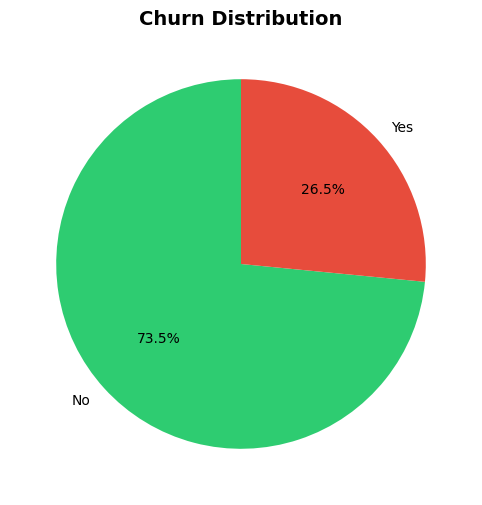

In [17]:
# chart: Churn Distribution
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'], startangle=90)
plt.title('Churn Distribution', fontweight='bold', fontsize=14)
plt.show()

### DATA PREPROCESSING

In [18]:
# Separate target and features
y = df['Churn']
X = df.drop(['customerID', 'Churn'], axis=1)

# Convert numeric columns
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

# Fill missing numeric values
X = X.fillna(X.median(numeric_only=True))

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = oe.fit_transform(X[categorical_cols])

# Save cleaned dataset
cleaned_df = pd.concat([X, y], axis=1)
cleaned_df.to_csv('Telecom_ChurnCleaned.csv', index=False)

# Summary
print(f"Preprocessed Data Shape: {X.shape}")
print(f"Features: {list(X.columns)[:5]}... (first 5)")

Preprocessed Data Shape: (7043, 19)
Features: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure']... (first 5)


### Apply SMOTE for balancing

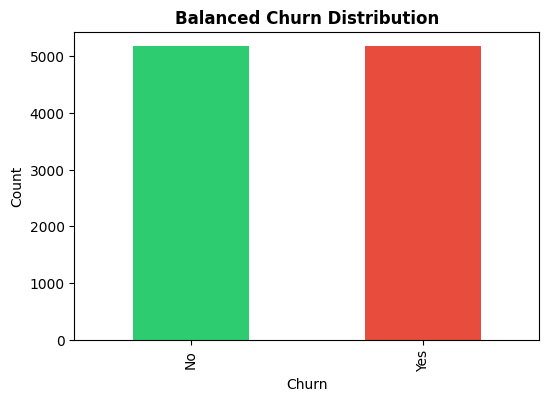

In [19]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X, y)

# Encode target to binary (0=No Churn, 1=Churn)
y_bal_encoded = y_bal.apply(lambda x: 1 if x == 'Yes' else 0)

# Visualize only the balanced distribution
plt.figure(figsize=(6,4))
y_bal.value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Balanced Churn Distribution', fontweight='bold', fontsize=12)
plt.ylabel('Count')
plt.show()

### TRAIN-TEST SPLIT & SCALING

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal_encoded, test_size=0.2, random_state=42, stratify=y_bal_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Summary
print(f"Train samples: {len(X_train):,}")
print(f"Test samples:  {len(X_test):,}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test):  {np.bincount(y_test)}")

Train samples: 8,278
Test samples:  2,070
Class distribution (train): [4139 4139]
Class distribution (test):  [1035 1035]


### Model Training & Evaluation

In [21]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("RANDOM FOREST RESULTS")
print(f"Best Params: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

RANDOM FOREST RESULTS
Best Params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 85.85%
ROC-AUC:  0.9372
F1-Score: 0.8588

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1035
           1       0.86      0.86      0.86      1035

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070

Confusion Matrix:
 [[886 149]
 [144 891]]


### Feature importance

Top 15 Most Important Features:
         Feature  Importance
        Contract    0.186550
          Tenure    0.110710
  MonthlyCharges    0.093288
    TotalCharges    0.092633
PaperlessBilling    0.080987
 InternetService    0.065614
     TechSupport    0.060103
  OnlineSecurity    0.057157
   PaymentMethod    0.046153
      Dependents    0.037102
         Partner    0.031010
    OnlineBackup    0.028797
          Gender    0.023214
   MultipleLines    0.020984
 StreamingMovies    0.018432


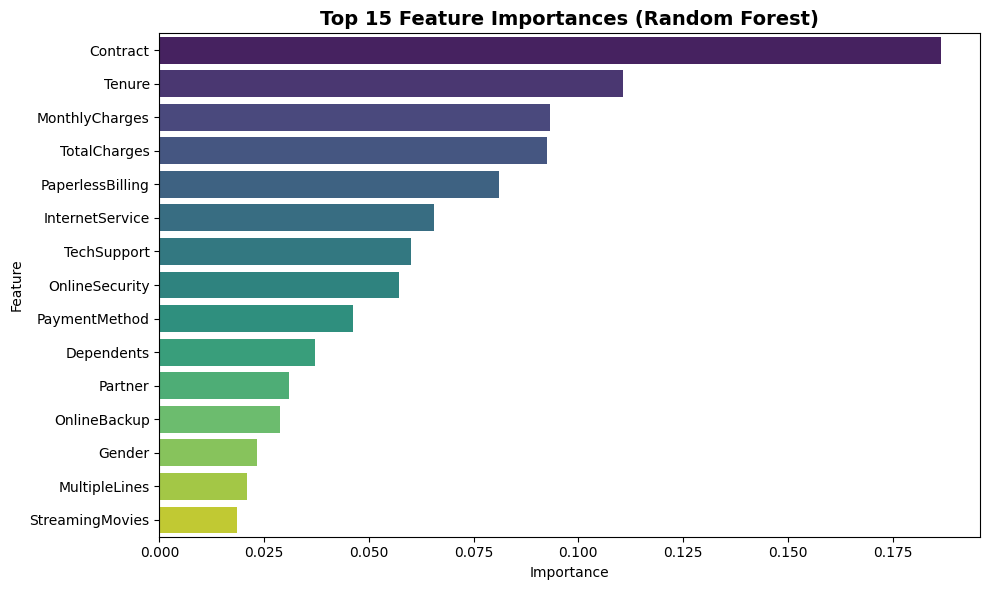

In [22]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 15
print("Top 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Model Comparison & Visualization

In [27]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'f1_score': f1_score(y_test, y_pred),
        'y_pred': y_pred, # Store predictions for confusion matrix
        'y_pred_proba': y_pred_proba # Store probabilities for ROC curve
    }

# Summary comparison
comparison_df = pd.DataFrame(results).T
comparison_df['accuracy'] = comparison_df['accuracy'] * 100
print(comparison_df.round(4))

# Best model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"\nBest Model: {best_model_name}")

                      accuracy   roc_auc  f1_score  \
Logistic Regression  77.971014  0.856666    0.7914   
Random Forest        85.700483  0.936362  0.856311   
Gradient Boosting    85.603865  0.937402  0.855199   

                                                                y_pred  \
Logistic Regression  [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...   
Random Forest        [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, ...   
Gradient Boosting    [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, ...   

                                                          y_pred_proba  
Logistic Regression  [0.0197307891227995, 0.892293057807743, 0.5555...  
Random Forest        [0.07833333333333334, 0.997007347678224, 0.678...  
Gradient Boosting    [0.028633760283111116, 0.9870557063645492, 0.7...  

Best Model: Random Forest


### Model Visualization

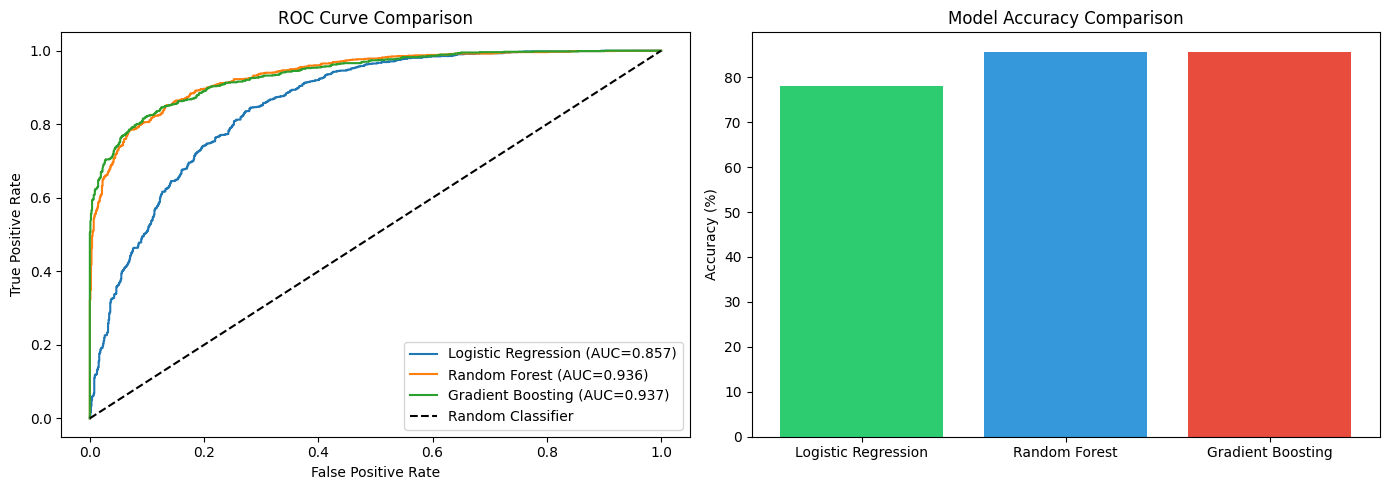

In [29]:
# ROC Curve & Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_title('ROC Curve Comparison')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Accuracy Bar Chart
model_names = list(results.keys())
accuracies = [result['accuracy'] * 100 for result in results.values()]
axes[1].bar(model_names, accuracies, color=['#2ecc71', '#3498db', '#e74c3c'])
axes[1].set_title('Model Accuracy Comparison')
axes[1].set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

### Confusion Matrices

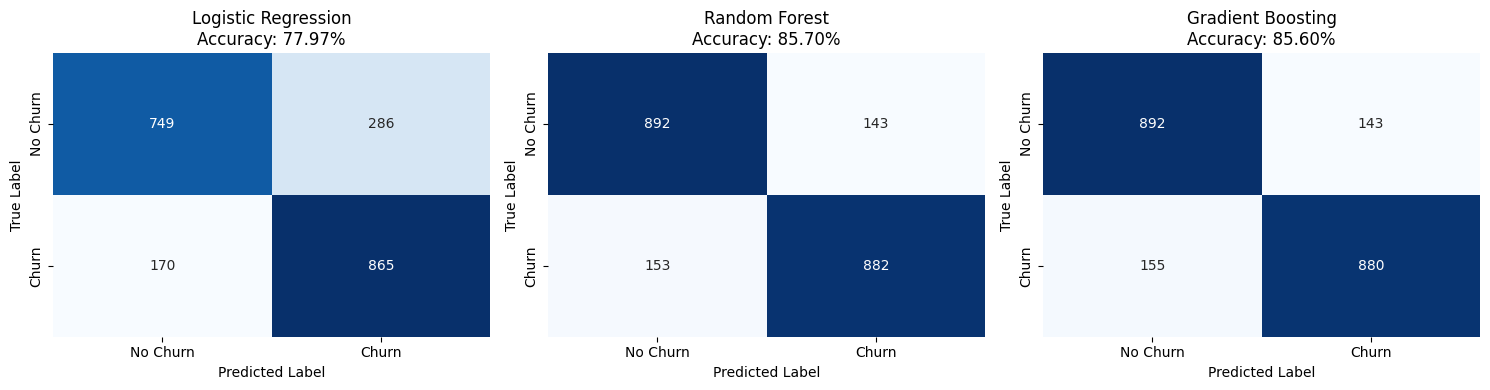

In [30]:
n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

if n_models == 1:
    axes = [axes]

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]*100:.2f}%')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()